In [25]:
#%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from collections import Counter
import seaborn as sn

sn.set_theme()

In [2]:
%%time
datasetPath = "../dataset/users_clean_with_indicators_no_outliers.h5"
df_users = pd.read_hdf(datasetPath)

CPU times: total: 141 ms
Wall time: 130 ms


In [3]:
df_users.head()

name lang  bot          created_at  statuses_count  \
2.353594e+09   lamonica raborn   en    1 2019-02-22 18:00:42              76   
2.358851e+09     lourie botton   en    0 2019-02-26 03:02:32              54   
1.379596e+08  dadan syarifudin   en    1 2015-04-30 07:09:56               3   
4.661248e+08    carletto focia   it    1 2017-01-18 02:49:18              50   
2.571494e+09         mbk ebook   en    0 2019-06-18 19:30:21            7085   

              tweet_count  retweet_made  retweet_made_ratio  reply_count_avg  \
2.353594e+09          120             0            0.000000              0.0   
2.358851e+09          104             0            0.000000              0.0   
1.379596e+08            3             0            0.000000              0.0   
4.661248e+08         1275             6            0.004706              0.0   
2.571494e+09         3277             0            0.000000              0.0   

              favorite_count_avg  ...  num_mentions_avg  tweet_length_avg  \
2.353594e+09            0.041667  ...          0.291667         62.366667   
2.358851e+09            0.057692  ...          0.365385         69.961538   
1.379596e+08            0.000000  ...          0.000000         17.333333   
4.661248e+08            0.189020  ...          0.007059         88.509804   
2.571494e+09            0.064693  ...          0.526396         73.673482   

              num_special_chars_avg  elapsed_time_entropy  \
2.353594e+09               3.958333              1.364257   
2.358851e+09               3.615385              1.335474   
1.379596e+08               4.333333              0.693147   
4.661248e+08               4.814118              4.130876   
2.571494e+09               3.671651              2.868727   

              reply_count_entropy  favorite_count_entropy  \
2.353594e+09                  0.0                0.173205   
2.358851e+09                  0.0                0.220570   
1.379596e+08                  0.0                0.000000   
4.661248e+08                  0.0                0.508540   
2.571494e+09                  0.0                0.243648   

              num_hashtags_entropy  num_urls_entropy  num_mentions_entropy  \
2.353594e+09              0.304947          0.000000              0.603637   
2.358851e+09              0.130708          0.000000              0.656454   
1.379596e+08              0.000000          0.000000              0.000000   
4.661248e+08              0.252911          0.117266              0.036302   
2.571494e+09              0.402308          0.007320              0.873255   

              tweet_length_entropy  
2.353594e+09              4.274598  
2.358851e+09              4.129301  
1.379596e+08              1.098612  
4.661248e+08              4.686233  
2.571494e+09              4.765100  

[5 rows x 22 columns]

In [4]:
df_users.dtypes

name                              object
lang                              object
bot                                int64
created_at                datetime64[ns]
statuses_count                     int64
tweet_count                        int64
retweet_made                       int64
retweet_made_ratio               float64
reply_count_avg                  float64
favorite_count_avg               float64
num_hashtags_avg                 float64
num_urls_avg                     float64
num_mentions_avg                 float64
tweet_length_avg                 float64
num_special_chars_avg            float64
elapsed_time_entropy             float64
reply_count_entropy              float64
favorite_count_entropy           float64
num_hashtags_entropy             float64
num_urls_entropy                 float64
num_mentions_entropy             float64
tweet_length_entropy             float64
dtype: object

array([[<AxesSubplot:title={'center':'tweet_count'}>]], dtype=object)

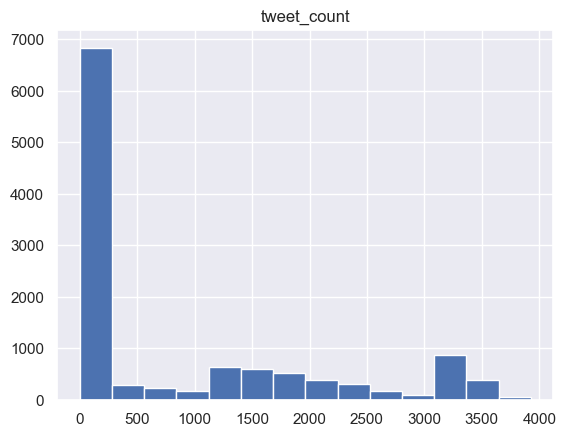

In [5]:
df_users.hist(column="tweet_count", stacked=True, bins=int(np.log2(df_users["tweet_count"].count()) + 1))

In [5]:
# delete categorical attributes
del df_users['name']
del df_users['lang']
del df_users['bot']
del df_users['created_at']

In [8]:
df_users.describe()

statuses_count   tweet_count  retweet_made  retweet_made_ratio  \
count    11508.000000  11508.000000  11508.000000        11508.000000   
mean      5750.093500    890.569604    164.359924            0.095118   
std      18752.596595   1163.881299    381.460515            0.169375   
min          0.000000      1.000000      0.000000            0.000000   
25%         42.000000     60.750000      0.000000            0.000000   
50%         71.000000    123.000000      0.000000            0.000000   
75%       2520.250000   1622.250000    104.000000            0.125000   
max     399555.000000   3926.000000   3247.000000            1.000000   

       reply_count_avg  favorite_count_avg  num_hashtags_avg  num_urls_avg  \
count     11508.000000        11508.000000      11508.000000  11508.000000   
mean          0.387964           17.336149          0.157817      0.091054   
std           8.208510          325.745417          0.231653      0.181418   
min           0.000000            0.000000          0.000000      0.000000   
25%           0.000000            0.024835          0.051546      0.000000   
50%           0.000000            0.066667          0.087585      0.018420   
75%           0.000000            0.275772          0.173913      0.079594   
max         663.813559        12311.636364          6.419856      2.000000   

       num_mentions_avg  tweet_length_avg  num_special_chars_avg  \
count      11508.000000      11508.000000           11508.000000   
mean           0.363099         69.431035               5.624068   
std            0.367852         16.491180               5.605126   
min            0.000000          3.000000               0.000000   
25%            0.011145         60.769032               3.727247   
50%            0.322034         66.705720               4.510450   
75%            0.532215         78.743056               5.722263   
max            5.796460        245.000000             145.500000   

       elapsed_time_entropy  reply_count_entropy  favorite_count_entropy  \
count          11508.000000         11508.000000            11508.000000   
mean               2.472382             0.045698                0.387626   
std                1.199069             0.143791                0.464316   
min                0.000000             0.000000                0.000000   
25%                1.324296             0.000000                0.103548   
50%                2.540036             0.000000                0.226497   
75%                3.479779             0.000000                0.503853   
max                5.757547             2.507112                4.788950   

       num_hashtags_entropy  num_urls_entropy  num_mentions_entropy  \
count          11508.000000      11508.000000          11508.000000   
mean               0.348029          0.170636              0.527054   
std                0.272968          0.223007              0.395255   
min                0.000000          0.000000              0.000000   
25%                0.192813          0.000000              0.050842   
50%                0.274967          0.087725              0.628035   
75%                0.453051          0.264447              0.806856   
max                2.210354          1.045909              2.225923   

       tweet_length_entropy  
count          11508.000000  
mean               3.966470  
std                0.872562  
min                0.000000  
25%                3.717905  
50%                4.202589  
75%                4.597572  
max                5.559428

Apply log scale to the skewed features

In [9]:
df_users.skew()

statuses_count             8.312859
tweet_count                1.109912
retweet_made               3.295766
retweet_made_ratio         2.214315
reply_count_avg           57.515113
favorite_count_avg        27.740746
num_hashtags_avg           5.779837
num_urls_avg               3.023711
num_mentions_avg           1.621925
tweet_length_avg           1.158283
num_special_chars_avg      8.539227
elapsed_time_entropy       0.172846
reply_count_entropy        5.822164
favorite_count_entropy     2.308280
num_hashtags_entropy       1.627854
num_urls_entropy           1.279533
num_mentions_entropy       0.044337
tweet_length_entropy      -2.029655
dtype: float64

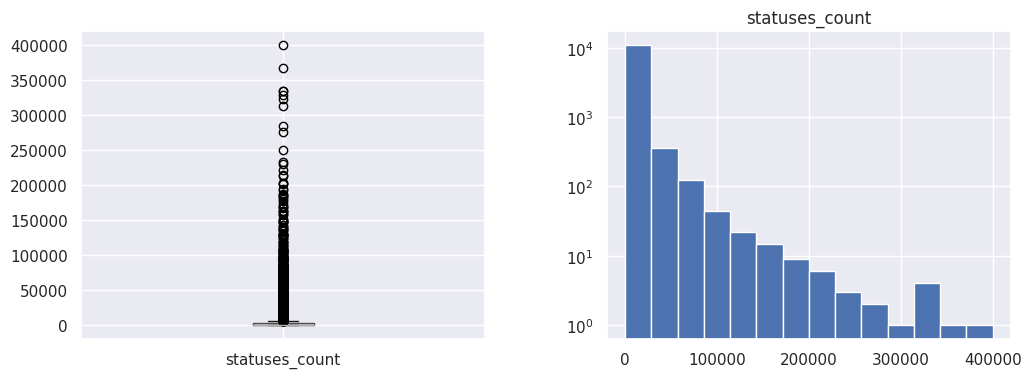

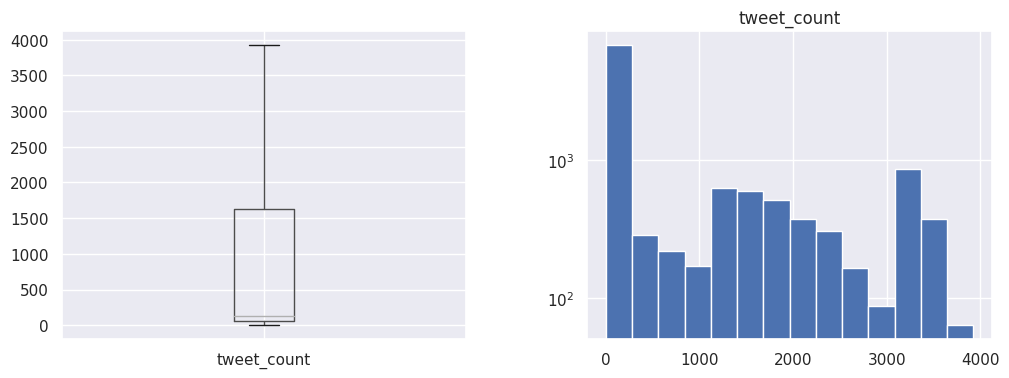

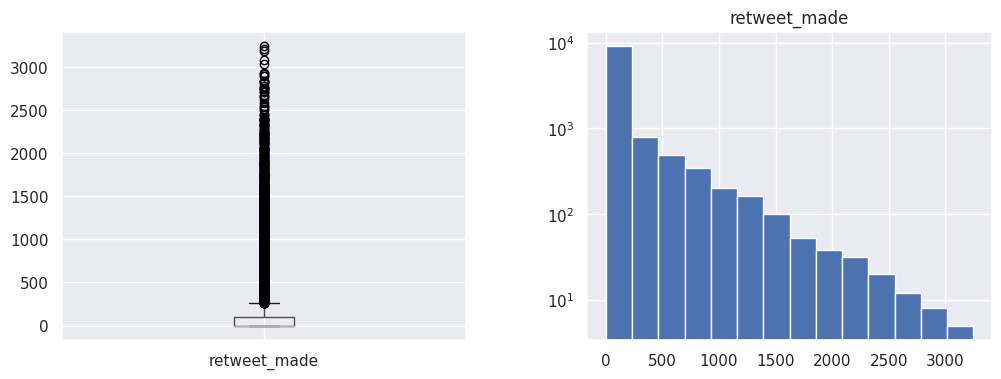

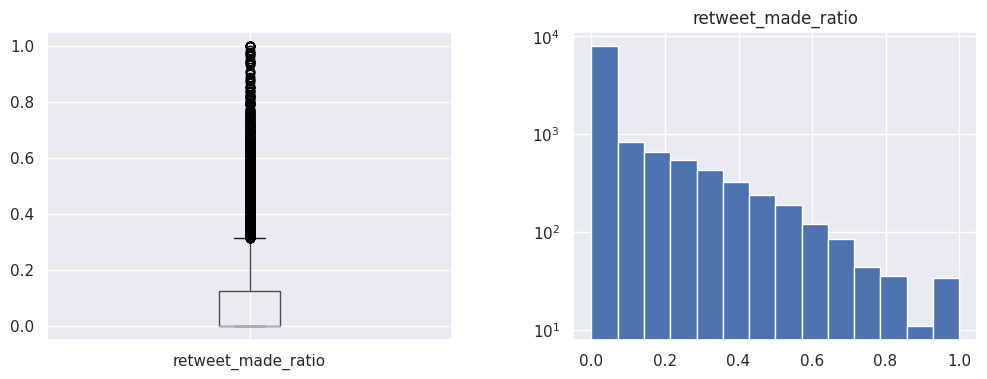

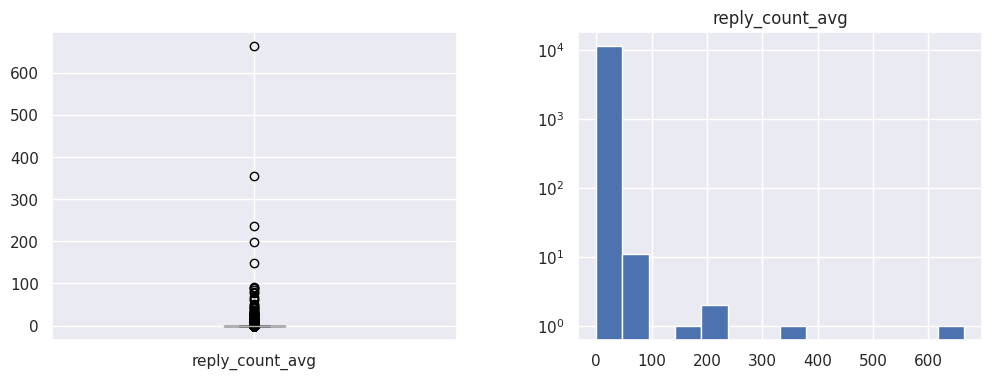

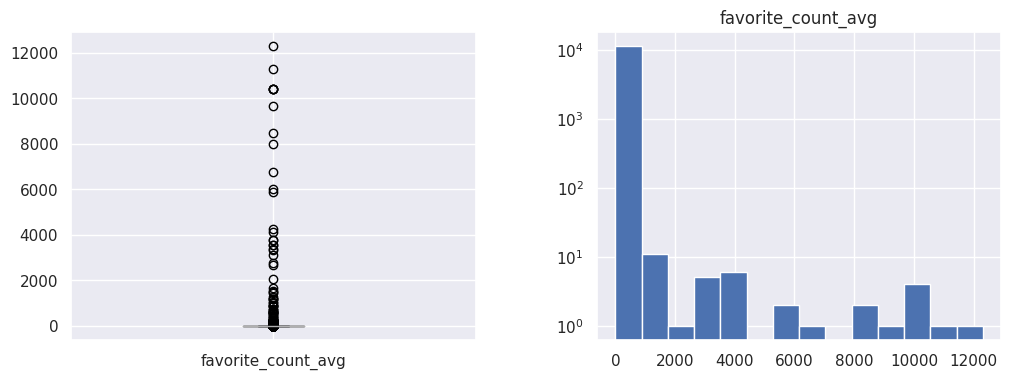

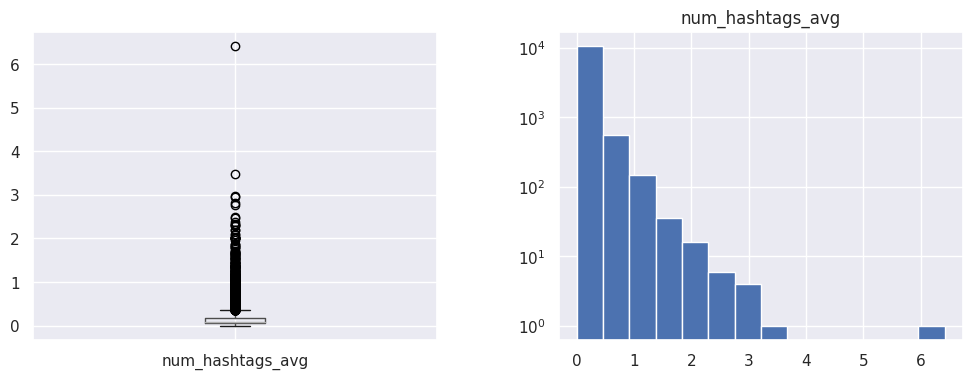

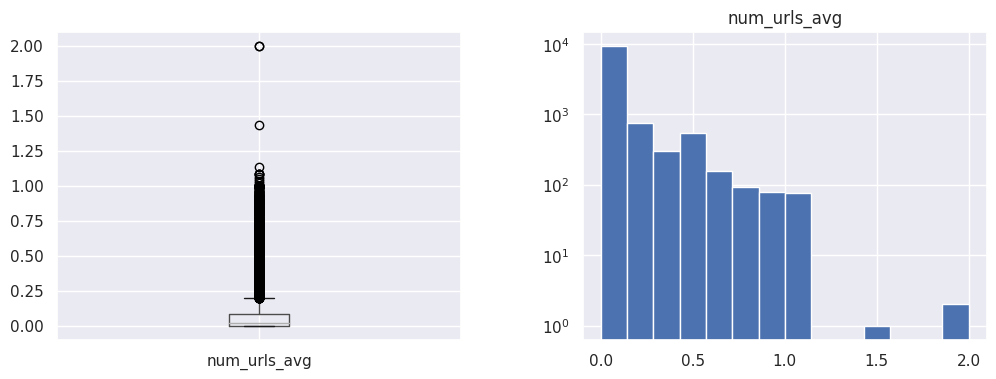

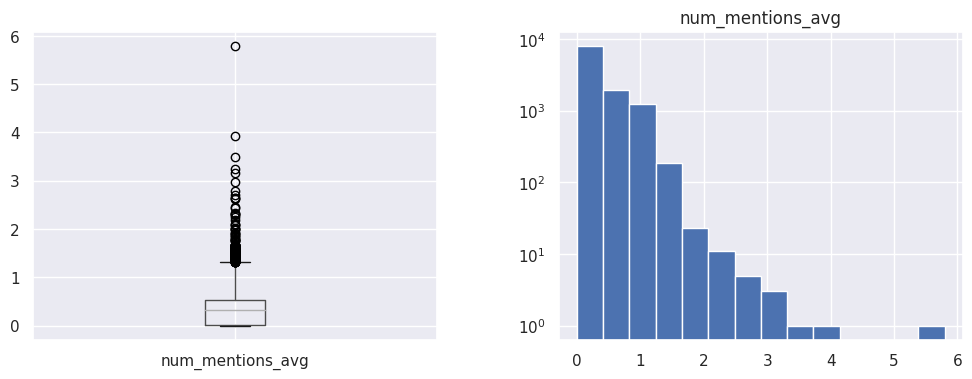

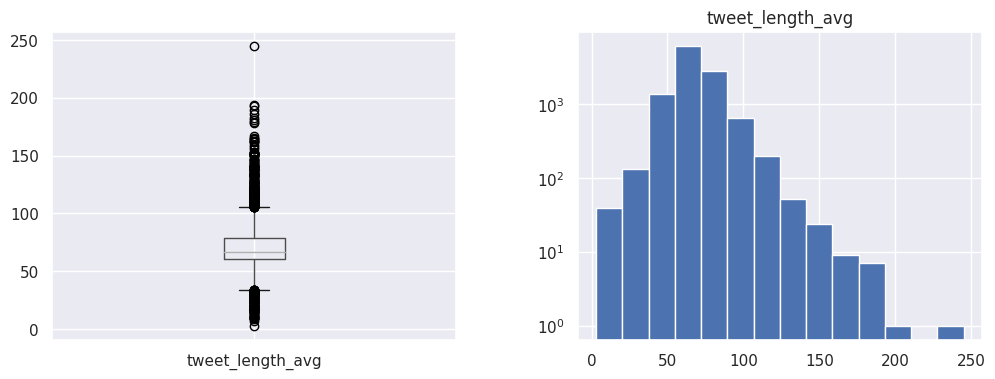

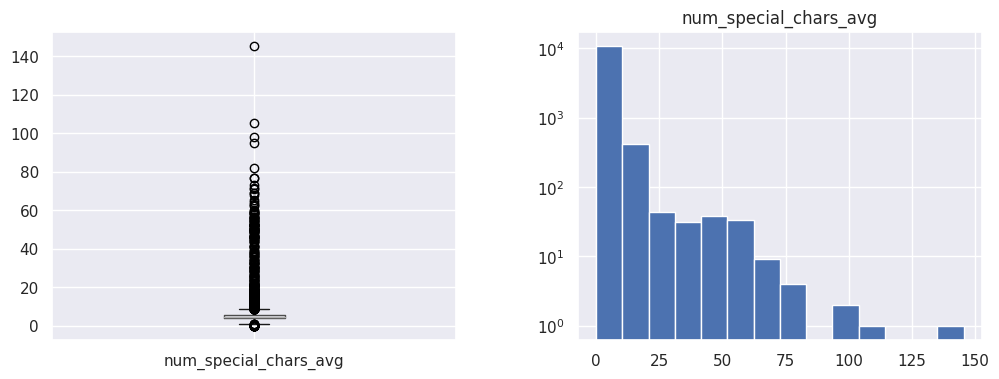

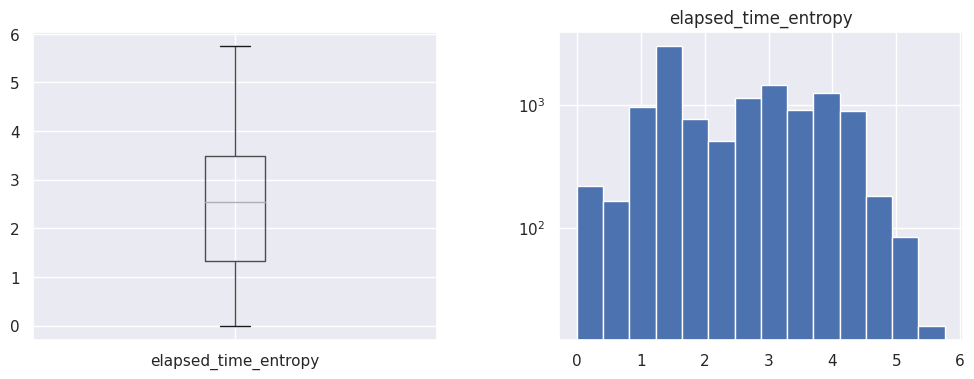

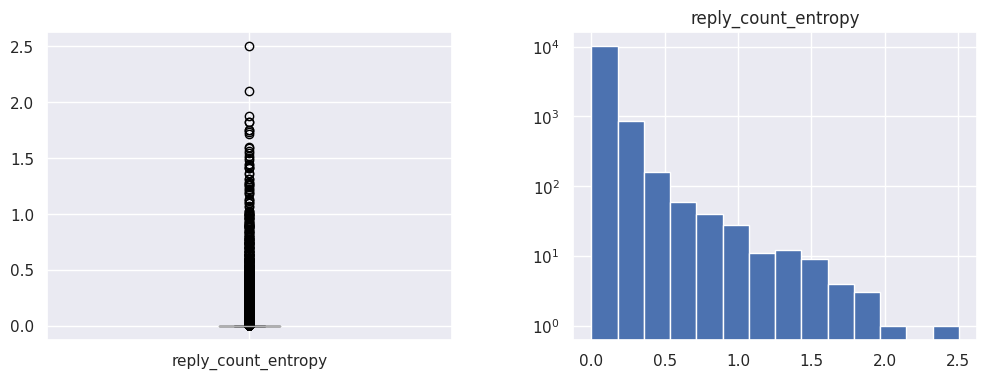

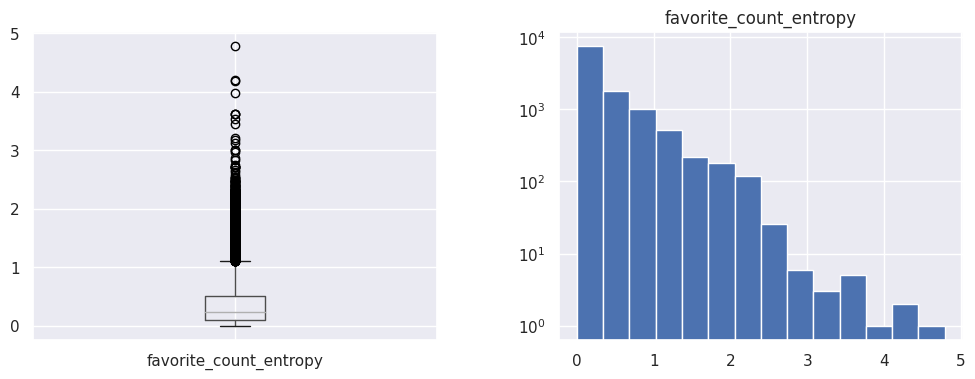

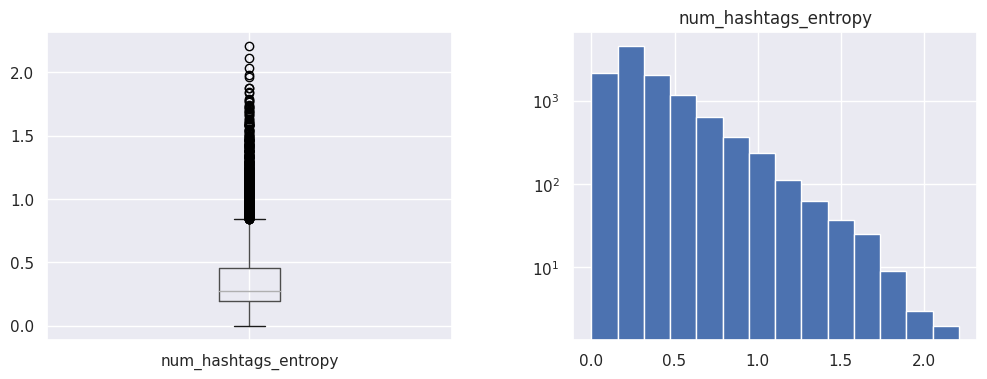

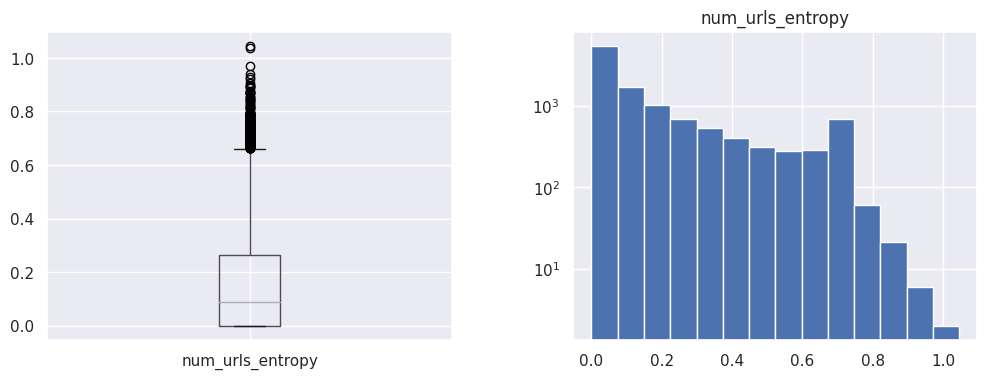

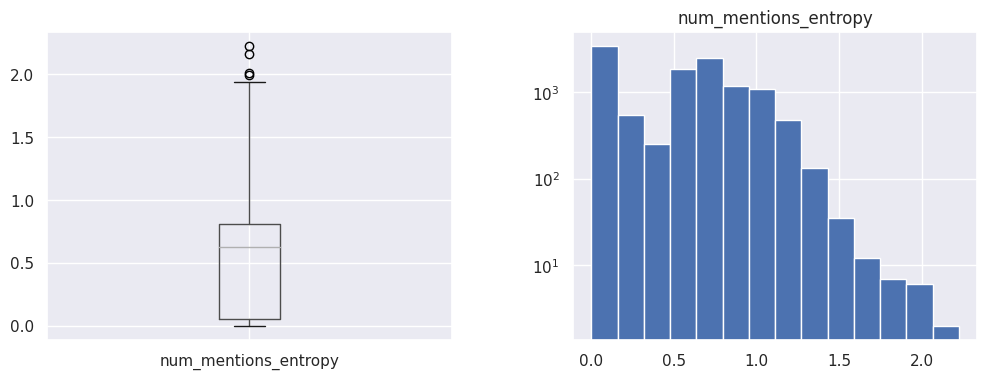

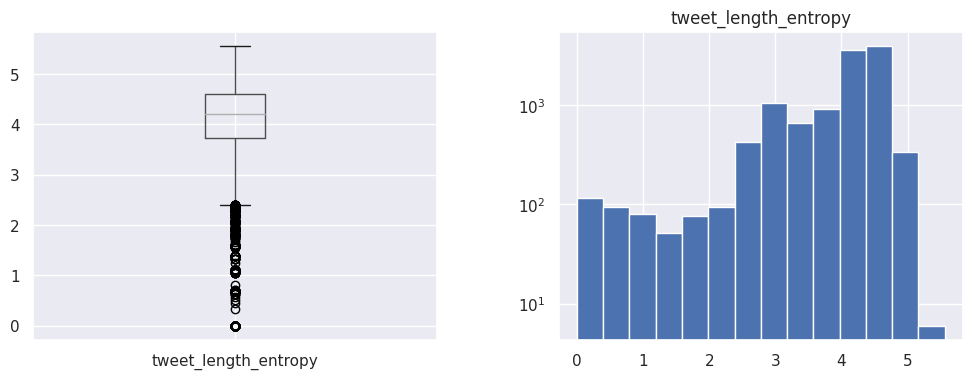

In [11]:
for column in df_users.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    df_users.boxplot(column=column, ax=ax1)
    df_users.hist(column=column, ax=ax2, stacked=True, bins=int(np.log2(df_users[column].count()) + 1))
    ax2.set_yscale('log')
    plt.title(column)
    plt.show()

In [6]:
df_users.statuses_count = np.log(df_users.statuses_count + 1)
df_users.tweet_count = np.log(df_users.tweet_count + 1)
df_users.retweet_made = np.log(df_users.retweet_made + 1)
df_users.retweet_made_ratio = np.log(df_users.retweet_made_ratio + 1)
df_users.reply_count_avg = np.log(df_users.reply_count_avg + 1)
df_users.favorite_count_avg = np.log(df_users.favorite_count_avg + 1)
df_users.num_hashtags_avg = np.log(df_users.num_hashtags_avg + 1)
df_users.num_urls_avg = np.log(df_users.num_urls_avg + 1)
df_users.num_mentions_avg = np.log(df_users.num_mentions_avg + 1)
df_users.tweet_length_avg = np.log(df_users.tweet_length_avg + 1)
df_users.num_special_chars_avg = np.log(df_users.num_special_chars_avg + 1)
df_users.reply_count_entropy = np.log(df_users.reply_count_entropy + 1)
df_users.favorite_count_entropy = np.log(df_users.favorite_count_entropy + 1)
df_users.num_hashtags_entropy = np.log(df_users.num_hashtags_entropy + 1)
df_users.num_urls_entropy = np.log(df_users.num_urls_entropy + 1)
df_users.tweet_length_entropy = np.log(df_users.tweet_length_entropy + 1)

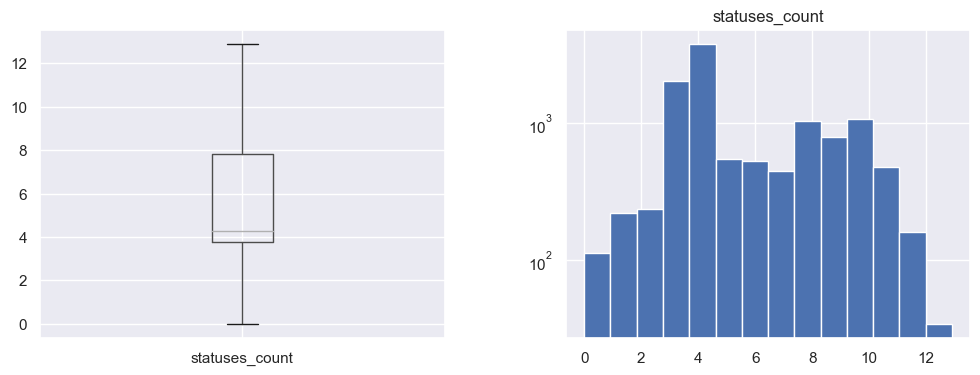

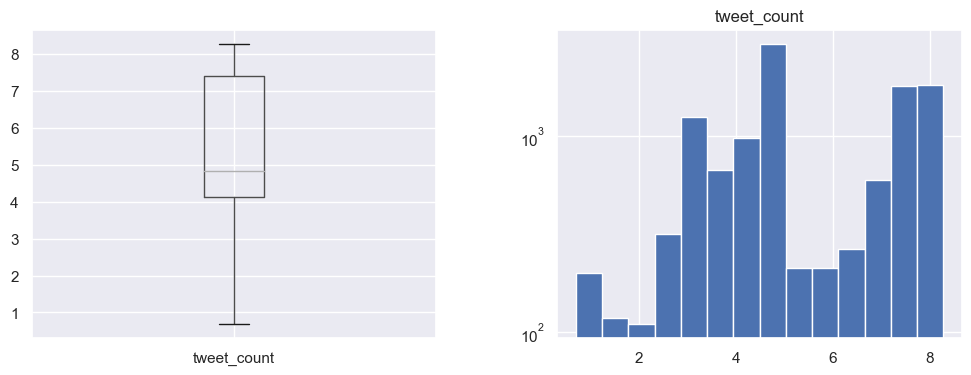

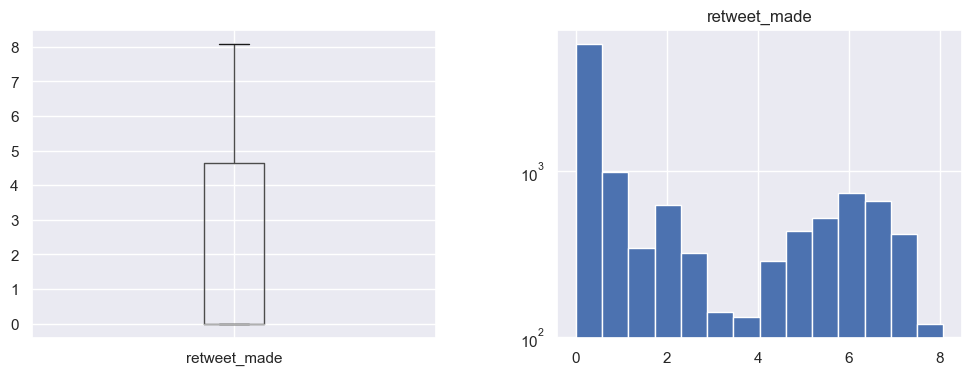

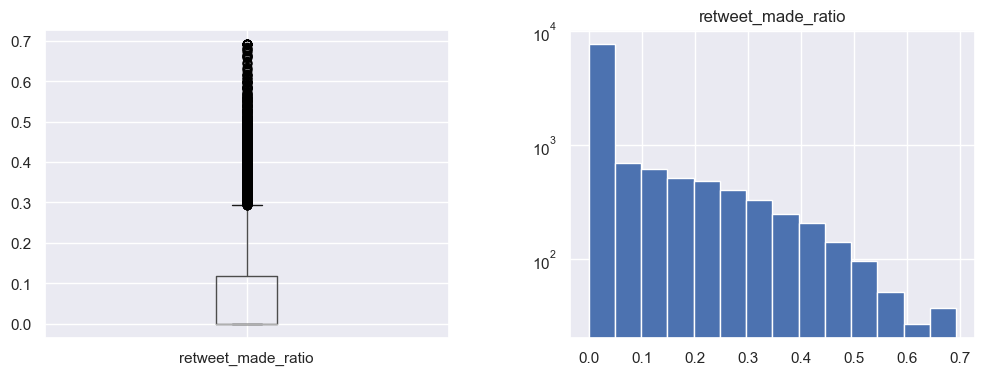

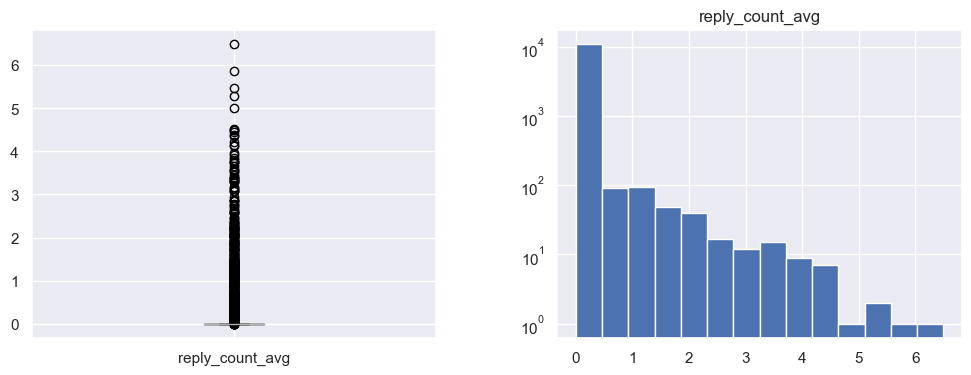

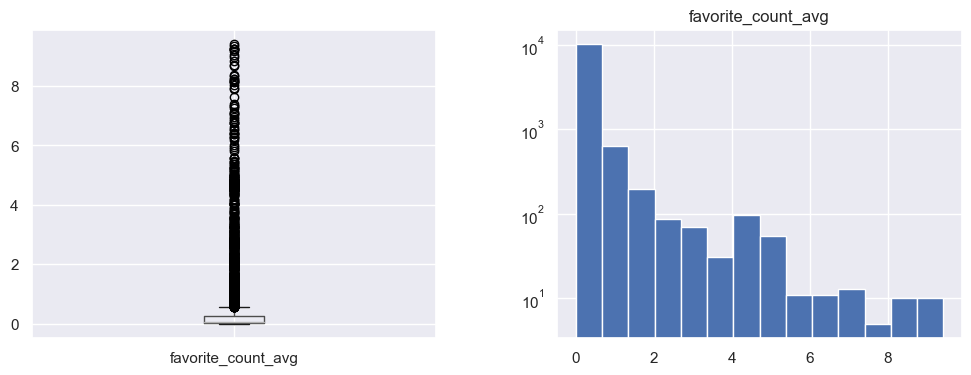

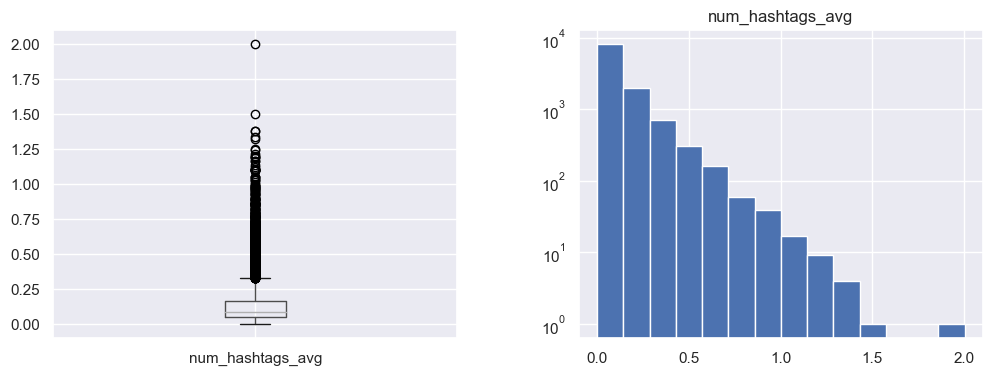

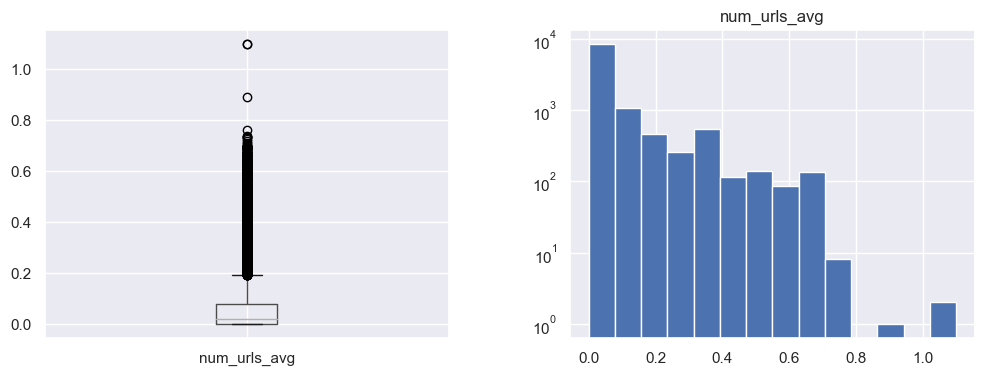

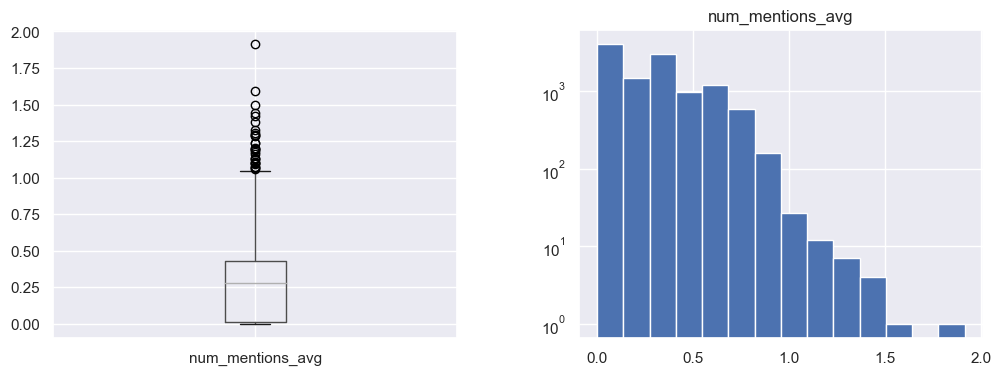

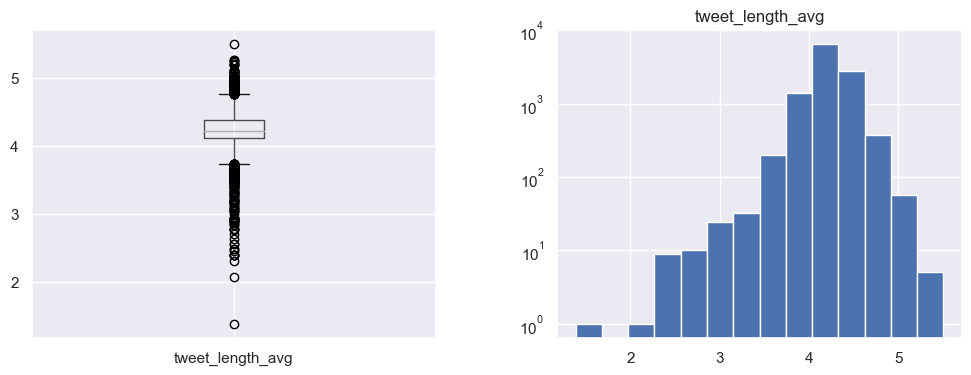

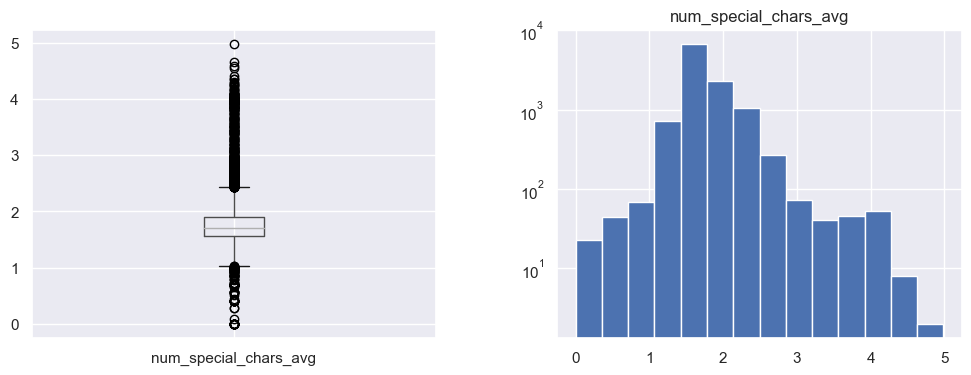

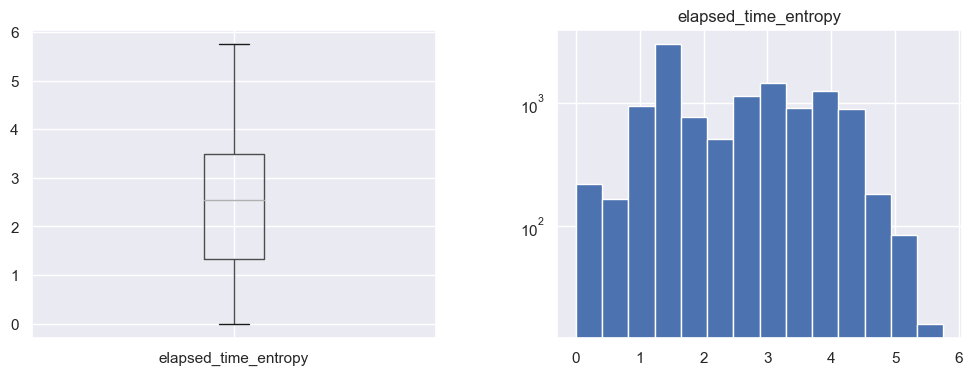

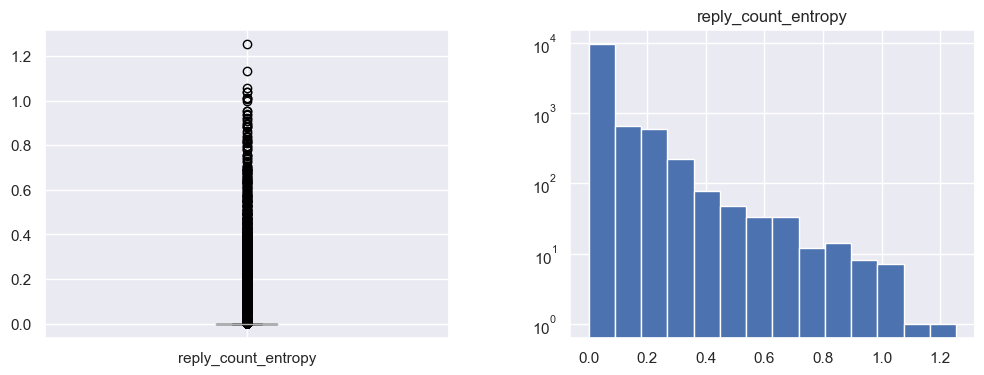

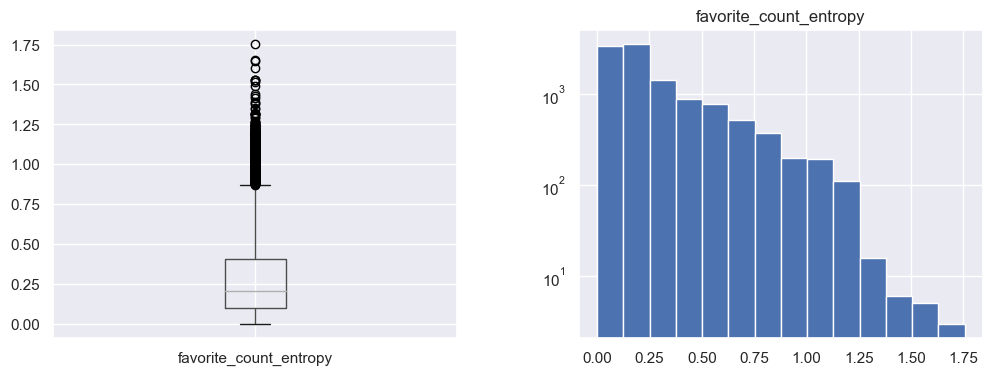

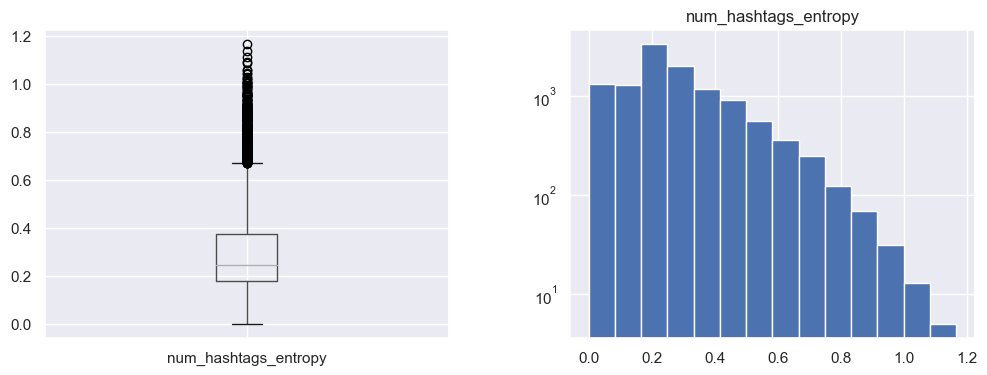

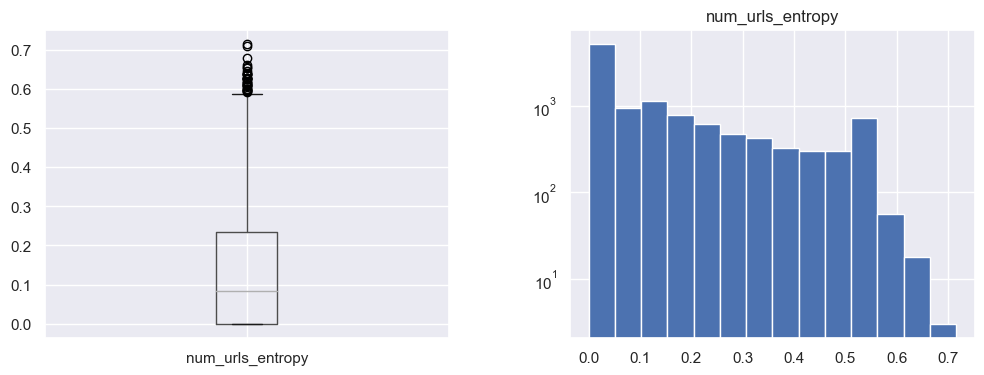

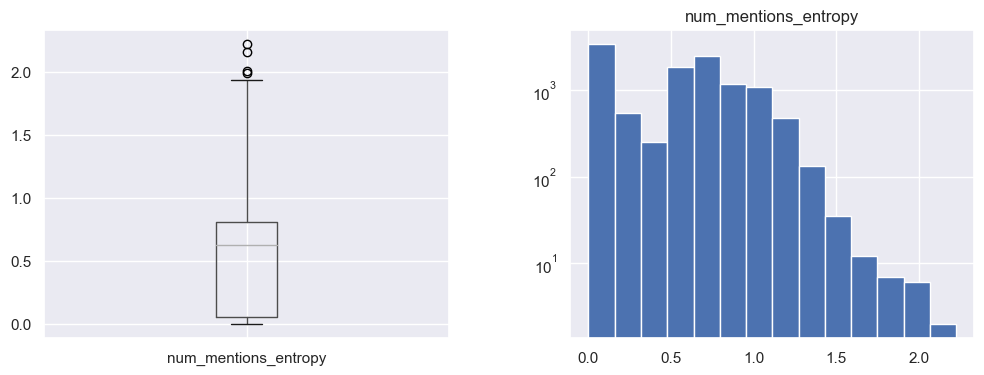

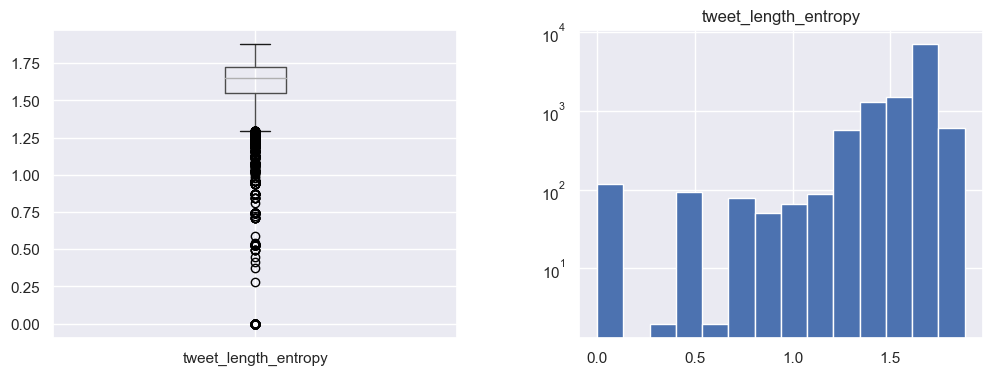

In [13]:
for column in df_users.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    df_users.boxplot(column=column, ax=ax1)
    df_users.hist(column=column, ax=ax2, stacked=True, bins=int(np.log2(df_users[column].count()) + 1))
    ax2.set_yscale('log')
    plt.title(column)
    plt.show()

In [11]:
df_users.describe()

statuses_count   tweet_count  retweet_made  retweet_made_ratio  \
count    11508.000000  11508.000000  11508.000000        11508.000000   
mean         5.606388      5.407964      2.036021            0.080843   
std          2.634090      1.933131      2.613812            0.135644   
min          0.000000      0.693147      0.000000            0.000000   
25%          3.761200      4.123069      0.000000            0.000000   
50%          4.276666      4.820282      0.000000            0.000000   
75%          7.832510      7.392186      4.653960            0.117783   
max         12.898109      8.275631      8.085795            0.693147   

       reply_count_avg  favorite_count_avg  num_hashtags_avg  num_urls_avg  \
count     11508.000000        11508.000000      11508.000000  11508.000000   
mean          0.064135            0.326521          0.133003      0.076359   
std           0.333340            0.852000          0.151673      0.138415   
min           0.000000            0.000000          0.000000      0.000000   
25%           0.000000            0.024532          0.050262      0.000000   
50%           0.000000            0.064539          0.083959      0.018252   
75%           0.000000            0.243551          0.160343      0.076585   
max           6.499507            9.418381          2.004160      1.098612   

       num_mentions_avg  tweet_length_avg  num_special_chars_avg  \
count      11508.000000      11508.000000           11508.000000   
mean           0.277990          4.227336               1.774373   
std            0.245566          0.239856               0.403034   
min            0.000000          1.386294               0.000000   
25%            0.011084          4.123402               1.553343   
50%            0.279171          4.215171               1.706646   
75%            0.426715          4.378810               1.905425   
max            1.916402          5.505332               4.987025   

       elapsed_time_entropy  reply_count_entropy  favorite_count_entropy  \
count          11508.000000         11508.000000            11508.000000   
mean               2.472382             0.038012                0.285620   
std                1.199069             0.106787                0.272024   
min                0.000000             0.000000                0.000000   
25%                1.324296             0.000000                0.098530   
50%                2.540036             0.000000                0.204162   
75%                3.479779             0.000000                0.408031   
max                5.757547             1.254793                1.755951   

       num_hashtags_entropy  num_urls_entropy  num_mentions_entropy  \
count          11508.000000      11508.000000          11508.000000   
mean               0.280756          0.141479              0.527054   
std                0.183814          0.174010              0.395255   
min                0.000000          0.000000              0.000000   
25%                0.176315          0.000000              0.050842   
50%                0.242921          0.084089              0.628035   
75%                0.373665          0.234635              0.806856   
max                1.166381          0.715842              2.225923   

       tweet_length_entropy  
count          11508.000000  
mean               1.578736  
std                0.250113  
min                0.000000  
25%                1.551365  
50%                1.649156  
75%                1.722333  
max                1.880903

In [12]:
df_users.head()

statuses_count  tweet_count  retweet_made  retweet_made_ratio  \
2.353594e+09        4.343805     4.795791       0.00000            0.000000   
2.358851e+09        4.007333     4.653960       0.00000            0.000000   
1.379596e+08        1.386294     1.386294       0.00000            0.000000   
4.661248e+08        3.931826     7.151485       1.94591            0.004695   
2.571494e+09        8.865876     8.094989       0.00000            0.000000   

              reply_count_avg  favorite_count_avg  num_hashtags_avg  \
2.353594e+09              0.0            0.040822          0.102857   
2.358851e+09              0.0            0.056089          0.028438   
1.379596e+08              0.0            0.000000          0.000000   
4.661248e+08              0.0            0.173129          0.079862   
2.571494e+09              0.0            0.062687          0.123564   

              num_urls_avg  num_mentions_avg  tweet_length_avg  \
2.353594e+09      0.000000          0.255933          4.148938   
2.358851e+09      0.000000          0.311436          4.262138   
1.379596e+08      0.000000          0.000000          2.908721   
4.661248e+08      0.024788          0.007034          4.494348   
2.571494e+09      0.000915          0.422909          4.313125   

              num_special_chars_avg  elapsed_time_entropy  \
2.353594e+09               1.601070              1.364257   
2.358851e+09               1.529395              1.335474   
1.379596e+08               1.673976              0.693147   
4.661248e+08               1.760289              4.130876   
2.571494e+09               1.541513              2.868727   

              reply_count_entropy  favorite_count_entropy  \
2.353594e+09                  0.0                0.159739   
2.358851e+09                  0.0                0.199318   
1.379596e+08                  0.0                0.000000   
4.661248e+08                  0.0                0.411142   
2.571494e+09                  0.0                0.218049   

              num_hashtags_entropy  num_urls_entropy  num_mentions_entropy  \
2.353594e+09              0.266163          0.000000              0.603637   
2.358851e+09              0.122844          0.000000              0.656454   
1.379596e+08              0.000000          0.000000              0.000000   
4.661248e+08              0.225470          0.110884              0.036302   
2.571494e+09              0.338120          0.007293              0.873255   

              tweet_length_entropy  
2.353594e+09              1.662902  
2.358851e+09              1.634969  
1.379596e+08              0.741276  
4.661248e+08              1.738048  
2.571494e+09              1.751822

In [7]:
def knn_dist_graph(X):
    klist = [3, 6, 9, 12]
    dist = pdist(X, 'euclidean') #pair wise distance
    dist = squareform(dist) #distance matrix given the vector dist
    fig = plt.figure(figsize=(12, 4))
    # Calculate sorted list of distances for points for each k
    for k in klist:
        kth_distances = list()
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])
        # Plot the graph of distance from k-th nearest neighbour
        plt.plot(range(0, len(kth_distances)), sorted(kth_distances), label=k)
        #plt.ylabel('dist from %sth neighbor' % k)
        plt.legend(loc="upper left")
        plt.xlabel('sorted distances')
        plt.tick_params(axis='both', which='major')
        plt.grid()

    plt.show()


## Choosing the features

In [14]:
df_users.columns

Index(['statuses_count', 'tweet_count', 'retweet_made', 'retweet_made_ratio',
       'reply_count_avg', 'favorite_count_avg', 'num_hashtags_avg',
       'num_urls_avg', 'num_mentions_avg', 'tweet_length_avg',
       'num_special_chars_avg', 'elapsed_time_entropy', 'reply_count_entropy',
       'favorite_count_entropy', 'num_hashtags_entropy', 'num_urls_entropy',
       'num_mentions_entropy', 'tweet_length_entropy'],
      dtype='object')

In [191]:
df_clustering = df_users[["statuses_count", "retweet_made_ratio", "elapsed_time_entropy"]]  # cluster about something

## DBSCAN

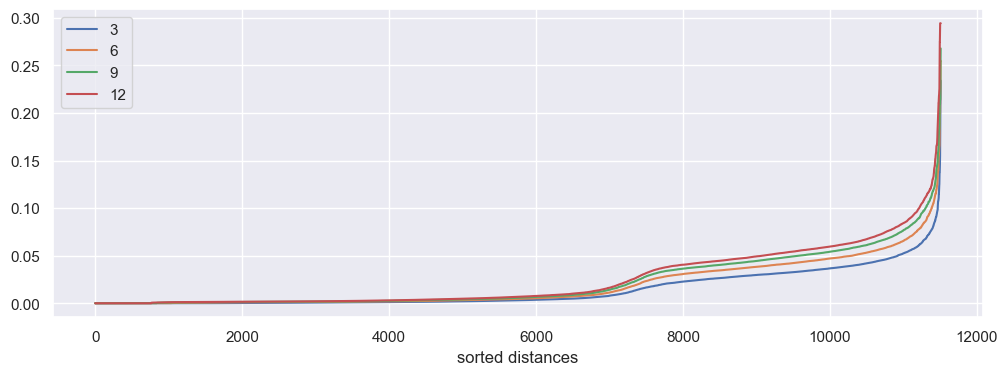

In [17]:
knn_dist_graph(X_minmax)

In [35]:
min_samples = np.arange(3, 21, 3)
# array of ranging from 0.1 to 0.6 with step of 0.1
eps_list = np.arange(0.2, 0.6, 0.1)
output = []
for ms in min_samples:
    for eps in eps_list:
        labels = DBSCAN(min_samples=ms, eps=eps).fit(df_users).labels_
        score = silhouette_score(df_users, labels)
        output.append((ms, eps, score))

min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")

Best silhouette_score: 0.24847279908252043
min_samples: 15
eps: 0.5000000000000001


### Min Max

In [ ]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(df_clustering.values)

In [36]:
dbscan = DBSCAN(min_samples=min_samples, eps=eps).fit(df_users).labels_
clusters = len(Counter(dbscan))
print(f"Number of clusters: {clusters}")
print(f"Number of outliers: {Counter(dbscan)[-1]}")
print(f"Silhouette_score: {silhouette_score(df_users, dbscan)}")
print('Separation %s' % davies_bouldin_score(X_minmax, dbscan))

Number of clusters: 28
Number of outliers: 4361
Silhouette_score: 0.24847279908252043
Separation 7.076766626904386


<AxesSubplot: xlabel='statuses_count', ylabel='retweet_made'>

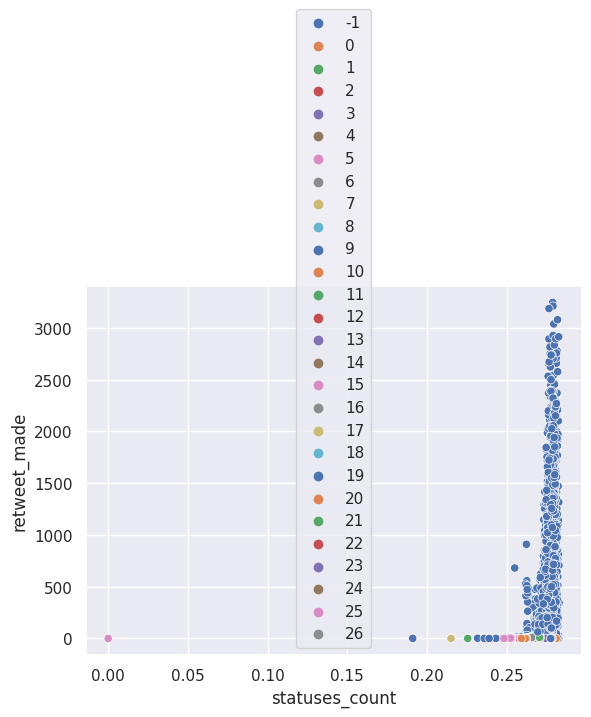

In [40]:
sn.scatterplot(data=df_users, x="statuses_count", y="retweet_made", hue=dbscan, palette=sn.color_palette(n_colors=clusters))

### Standard Scaler

In [76]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df_users.values)

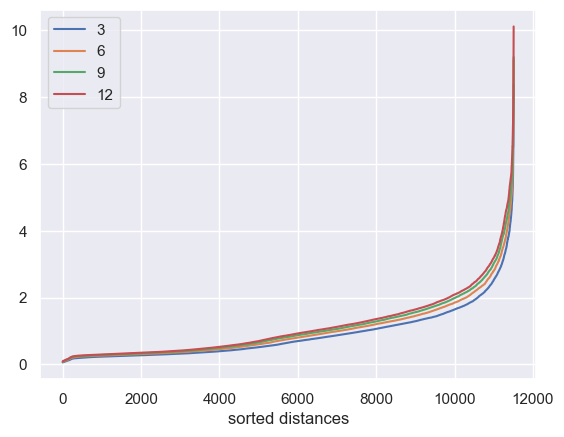

In [77]:
knn_dist_graph(X_std)

In [43]:
min_samples = np.arange(3, 21, 3)
# array of ranging from 1 to 4 with step of 0.5
eps_list = np.arange(1, 4, 0.5)
output = []
for ms in min_samples:
    for eps in eps_list:
        labels = DBSCAN(min_samples=ms, eps=eps).fit(df_users).labels_
        score = silhouette_score(df_users, labels)
        output.append((ms, eps, score))

min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")

Best silhouette_score: 0.18691970460825338
min_samples: 12
eps: 1.5


In [55]:
dbscan = DBSCAN(min_samples=min_samples, eps=eps).fit(df_users).labels_
clusters = len(Counter(dbscan))
print(f"Number of clusters: {clusters}")
print(f"Number of outliers: {Counter(dbscan)[-1]}")
print(f"Silhouette_score: {silhouette_score(df_users, dbscan)}")
print('Separation %s' % davies_bouldin_score(X_std, dbscan))

Number of clusters: 21
Number of outliers: 3635
Silhouette_score: 0.18691970460825338
Separation 1.6186522749343248


<AxesSubplot:xlabel='favorite_count', ylabel='tweet_count'>

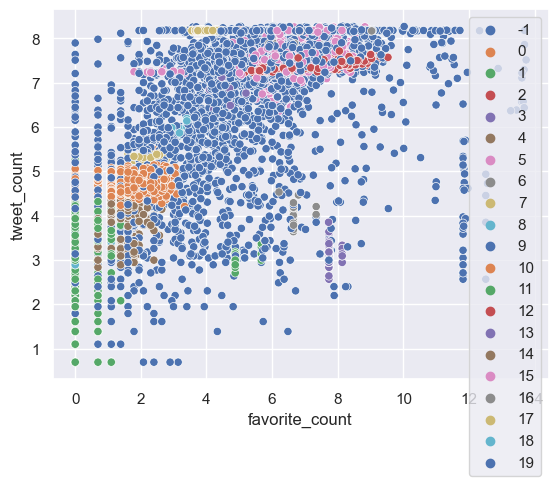

In [51]:
sn.scatterplot(data=df_users, x="favorite_count", y="tweet_count", hue=dbscan, palette=sn.color_palette(n_colors=clusters))

# KMeans

In [11]:
def plot_indicators(sse_list, sil_list, sep_list):
    # SSE
    plt.plot(range(2, len(sse_list) + 2), sse_list)
    plt.ylabel('SSE')
    plt.xlabel('K')
    plt.xticks(range(2, len(sse_list) + 2))
    plt.savefig("../images/clustering/kmeans_sse.png")
    plt.show()

    # Silhouette
    plt.plot(range(2, len(sil_list) + 2), sil_list)
    plt.ylabel('Silouettes')
    plt.xlabel('K')
    plt.xticks(range(2, len(sil_list) + 2))
    plt.savefig("../images/clustering/kmeans_silouettes.png")
    plt.show()

    # Davies-Bouldin Score
    plt.plot(range(2, len(sep_list) + 2), sep_list)
    plt.ylabel('Separation')
    plt.xlabel('K')
    plt.xticks(range(2, len(sep_list) + 2))
    plt.savefig("../images/clustering/kmeans_separation.png")
    plt.show()

def k_means(X, max_k):
    sse_list = list()
    separations = list()
    silouettes = list()

    for k in tqdm(range(2, max_k + 1), total=max_k - 1, desc="Iterating over {0} possible K values".format(max_k)):
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
        kmeans.fit(X)
        
        separations.append(davies_bouldin_score(X, kmeans.labels_))
        silouettes.append(silhouette_score(X, kmeans.labels_))
        sse = kmeans.inertia_
        sse_list.append(sse)

    return sse_list, silouettes, separations

def plot_similarity_heatmap(df, labels):
    df_plot = pd.DataFrame(df, copy=True)
    df_plot['cluster'] = labels
    columns = df_plot.columns[0:-1]
    df_plot.sort_values(by='cluster', ascending=True, inplace=True)
    dist = euclidean_distances(df_plot.loc[:, columns], df_plot.loc[:, columns])
    sim = np.exp(-dist)
    fig, ax = plt.subplots(figsize=(12,8))
    sn.heatmap(sim, ax=ax, cmap='coolwarm')

### Min Max

In [192]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(df_clustering.values)

In [193]:
sse, sil, davies_bouldin = k_means(X_minmax, 20)

Iterating over 20 possible K values: 100%|██████████| 19/19 [01:26<00:00,  4.53s/it]


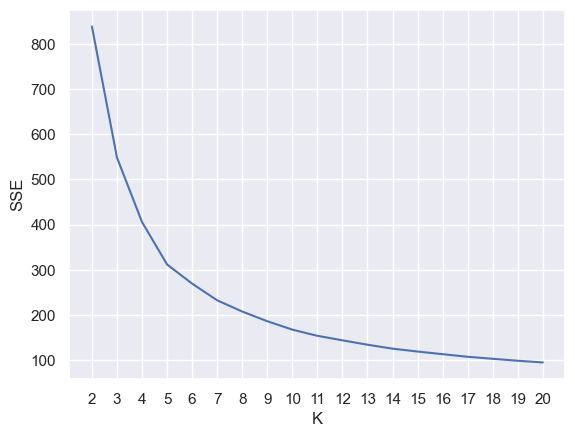

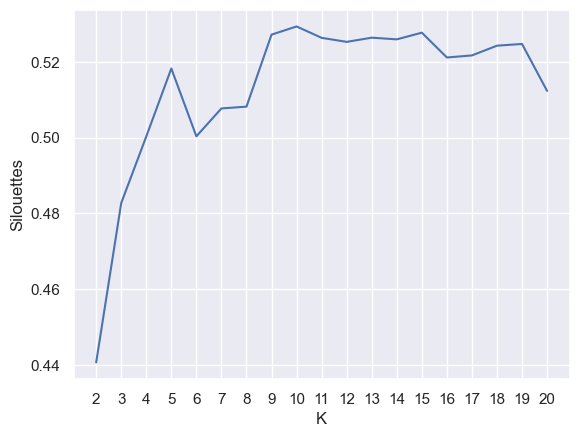

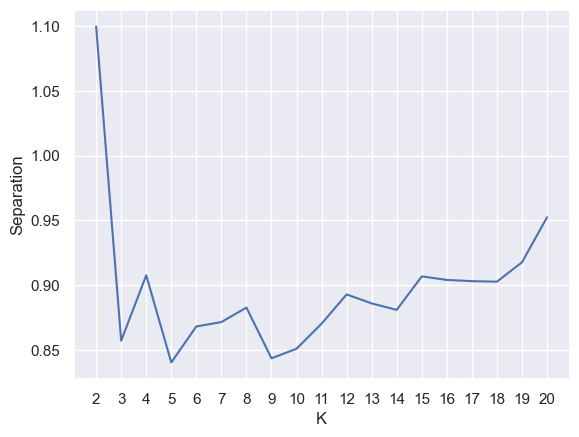

In [194]:
plot_indicators(sse, sil, davies_bouldin)

In [196]:
best_k = 6  # best k value
kmeans = KMeans(n_clusters=best_k, n_init=300)
kmeans.fit(X_minmax)
print("SSE:", sse[best_k-2], " - SILHOUETTE:", sil[best_k-2])

SSE: 269.121948123728  - SILHOUETTE: 0.5003234968407686


In [ ]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
clust_dict = dict(zip(bins, hist))
print(clust_dict)

{0: 1711, 1: 3691, 2: 1283, 3: 3328, 4: 1495}


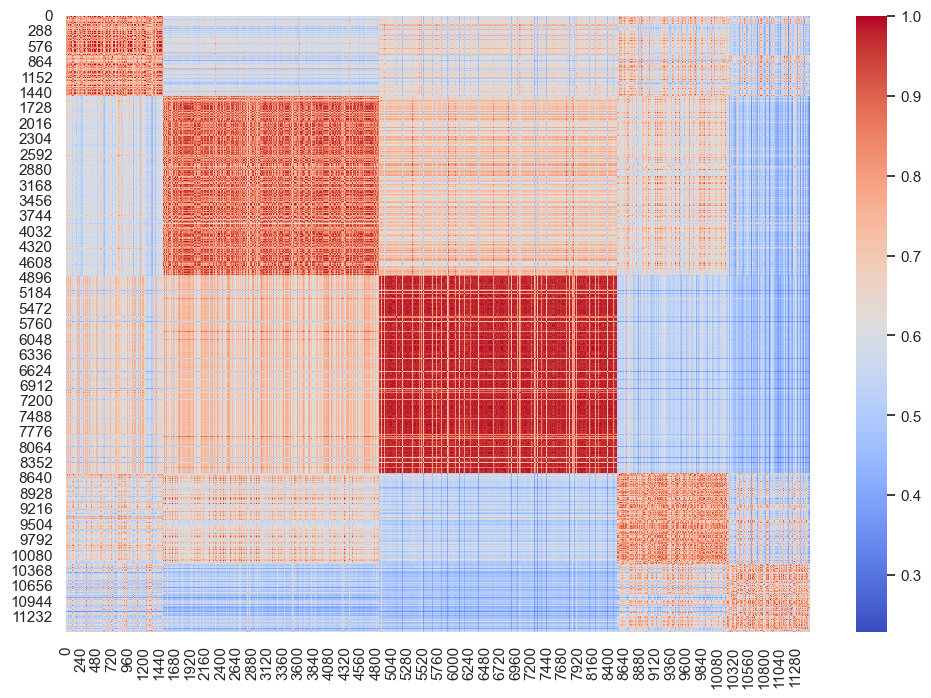

In [18]:
plot_similarity_heatmap(X_minmax, kmeans.labels_)

In [197]:
df_cluster = df_clustering.copy()
df_cluster["cluster"] = kmeans.labels_  # insert the column "cluster"
df_cluster.groupby("cluster").mean()

statuses_count  retweet_made_ratio  elapsed_time_entropy
cluster                                                          
0              3.744328            0.002787              1.225029
1              8.495445            0.412842              2.234860
2              5.317866            0.022033              4.102849
3              8.213444            0.204909              3.727720
4              9.271863            0.065746              1.820692
5              3.278062            0.028625              2.991684

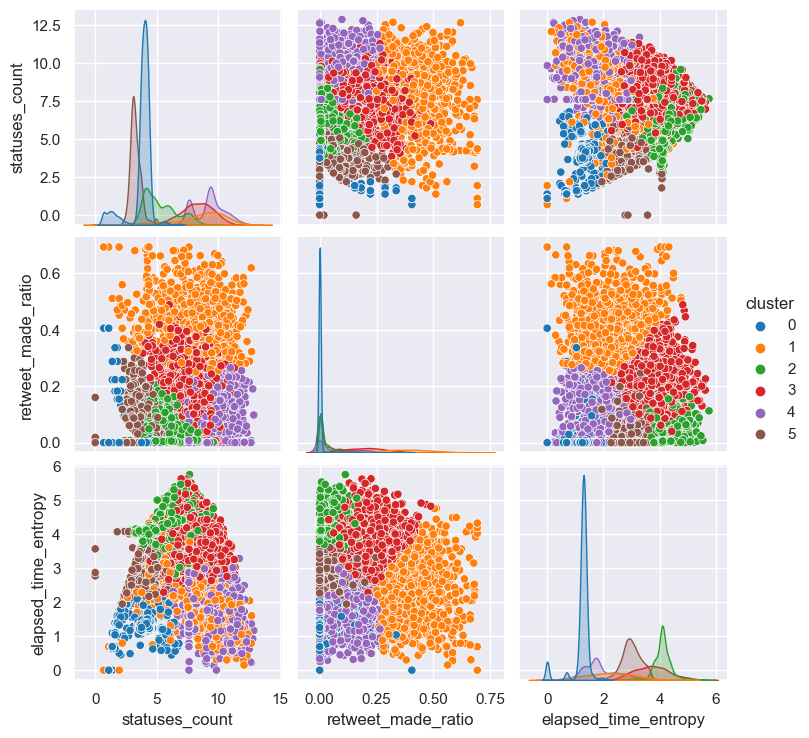

In [198]:
sn.pairplot(df_cluster, hue='cluster', palette='tab10')

In [38]:
df_users[df_users.statuses_count == df_users.statuses_count.min()]

statuses_count  tweet_count  retweet_made  retweet_made_ratio  \
1.127238e+09             0.0     3.044522      0.000000            0.000000   
6.162857e+08             0.0     3.988984      0.693147            0.018692   
1.128635e+09             0.0     3.178054      1.609438            0.160343   
1.174361e+09             0.0     3.044522      0.000000            0.000000   

              reply_count_avg  favorite_count_avg  num_hashtags_avg  \
1.127238e+09         0.000000            0.000000          0.095310   
6.162857e+08         0.018692            0.055060          0.107246   
1.128635e+09         0.122602            1.127186          0.160343   
1.174361e+09         0.095310            0.000000          0.139762   

              num_urls_avg  num_mentions_avg  tweet_length_avg  \
1.127238e+09      0.000000          0.000000          3.909018   
6.162857e+08      0.037041          0.018692          4.203566   
1.128635e+09      0.083382          0.160343          4.262680   
1.174361e+09      0.048790          0.000000          4.224642   

              num_special_chars_avg  elapsed_time_entropy  \
1.127238e+09               1.848455              2.871476   
6.162857e+08               2.332327              3.570955   
1.128635e+09               2.090252              2.775976   
1.174361e+09               2.667228              2.871476   

              reply_count_entropy  favorite_count_entropy  \
1.127238e+09             0.000000                0.000000   
6.162857e+08             0.089475                0.171292   
1.128635e+09             0.304327                0.304327   
1.174361e+09             0.181083                0.000000   

              num_hashtags_entropy  num_urls_entropy  num_mentions_entropy  \
1.127238e+09              0.281475          0.000000              0.000000   
6.162857e+08              0.302450          0.149007              0.093600   
1.128635e+09              0.379831          0.258850              0.462037   
1.174361e+09              0.332463          0.181083              0.000000   

              tweet_length_entropy  
1.127238e+09              1.349916  
6.162857e+08              1.571394  
1.128635e+09              1.404925  
1.174361e+09              1.331782

<AxesSubplot:xlabel='PC_1', ylabel='PC_2'>

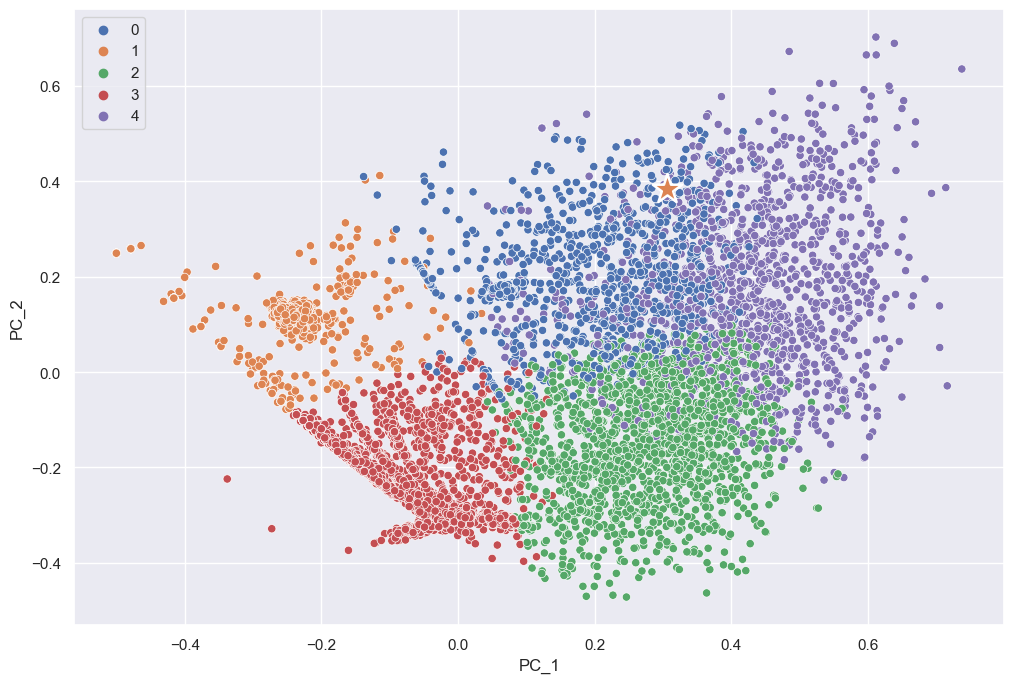

In [118]:
pca = PCA(n_components=2)
data_to_visualize = pd.DataFrame(pca.fit_transform(X_minmax), columns=['PC_1','PC_2'], index=df_users.index)
data_to_visualize['cluster'] = pd.Categorical(kmeans.labels_)
plt.figure(figsize=(12,8))
sn.scatterplot(x="PC_1", y="PC_2", hue="cluster", data=data_to_visualize)

max_statuses_count_user = df_users[df_users.statuses_count == df_users.statuses_count.max()]
a = data_to_visualize.loc[max_statuses_count_user.index, 'PC_1']
b = data_to_visualize.loc[max_statuses_count_user.index, 'PC_2']
sn.scatterplot(x=a, y=b, s=500, marker='*')
#plt.text(x=a-3, y=b-0.14, s="Gustavo Milan", fontdict=dict(color='black', alpha=0.5, size=16))

In [137]:
centers = np.array(kmeans.cluster_centers_)
df_centr = pd.DataFrame(centers, columns=df_clustering.columns)
df_centr

statuses_count  retweet_made_ratio  elapsed_time_entropy
0        0.610298            0.196475              0.682434
1        0.289173            0.004735              0.215210
2        0.650834            0.568292              0.431129
3        0.293517            0.032863              0.589567
4        0.721570            0.100378              0.310712

In [147]:
def plot_centers(X, centers, columns, labels):
    pca_to_visualize = PCA(n_components=2)
    data_to_visualize = pd.DataFrame(pca_to_visualize.fit_transform(X), columns=['PC_1','PC_2'])
    centers_to_visualize = pca_to_visualize.fit_transform(centers)
    
    plt.figure(figsize=(12,8))
    cmap = sn.color_palette("flare", as_cmap=True)
    plt.scatter(data_to_visualize['PC_1'], data_to_visualize['PC_2'], c=labels, s=20, cmap=cmap)
    plt.scatter(centers_to_visualize[:, 0], centers_to_visualize[:, 1], s=300, marker='*', c='red')
    plt.xlabel('PC_1')
    plt.ylabel('PC_2')
    plt.show()

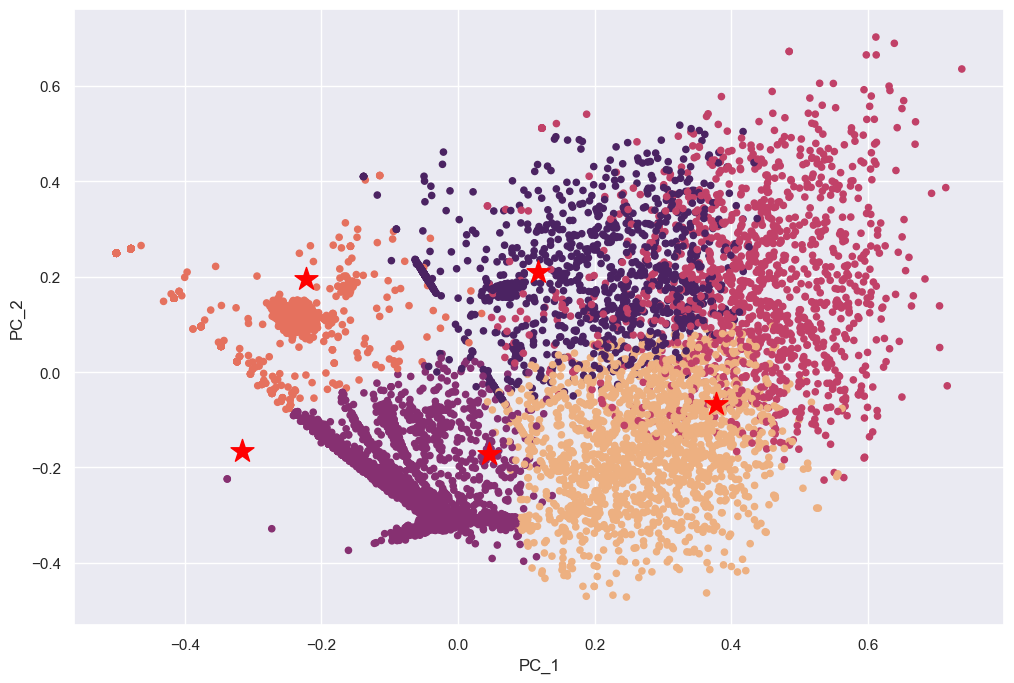

In [148]:
plot_centers(X_minmax, centers, df_clustering.columns, kmeans.labels_)

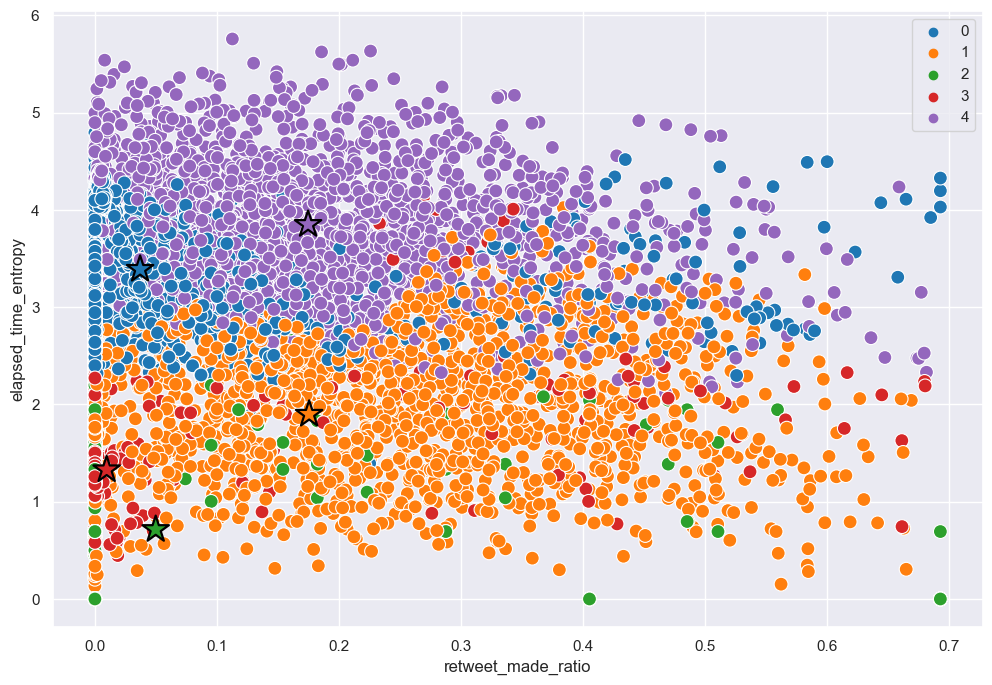

In [164]:
plt.figure(figsize=(12, 8))
ax = sn.scatterplot(x="retweet_made_ratio", y="elapsed_time_entropy", data=df_cluster, hue=kmeans.labels_, palette="tab10", s=100)
ax = sn.scatterplot(x=kmeans.cluster_centers_[:, 1], y=kmeans.cluster_centers_[:, 2],
                     hue=range(best_k), palette="tab10", marker='*', s=400, ec='black', legend=False, ax=ax)
plt.show()

### Standard Scaler

In [47]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df_users.values)

In [48]:
sse, sil, davies_bouldin = k_means(X_std, 20)

Iterating over 20 possible K values: 100%|██████████| 19/19 [01:47<00:00,  5.64s/it]


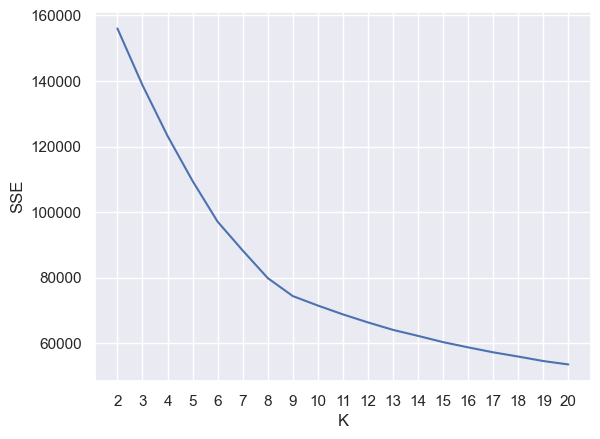

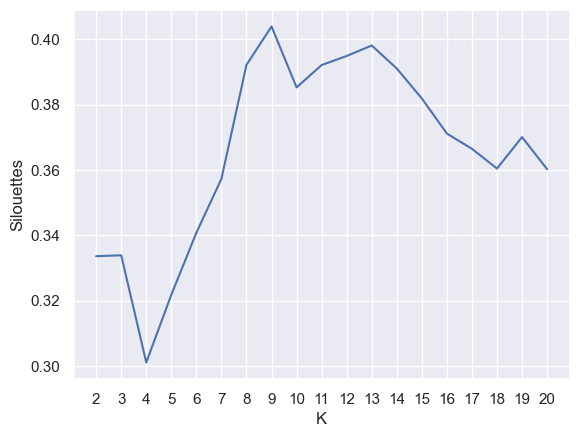

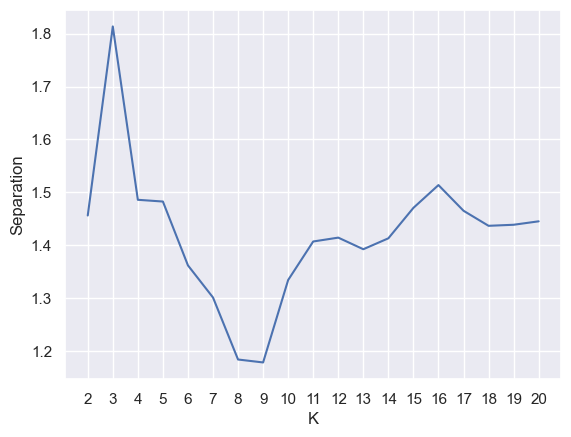

In [49]:
plot_indicators(sse, sil, davies_bouldin)